<h2 style="color:blue" align="center">Deep Neural Network (DNN) for Classification on MNIST</h2>

#### Import the necessary libraries

In [158]:
import tensorflow as tf 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import random as python_random
import time, math 

from tensorflow import keras 
from keras.models import Sequential
from keras.layers import Dense 
from keras.callbacks import Callback, CSVLogger

import warnings
warnings.filterwarnings('ignore')

#### Reserve memory for the execution

In [159]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


#### Load and split the dataset into training and testing set

MNIST - Handwritten digits recognition

In [160]:
(X_train,y_train),(X_test,y_test) = keras.datasets.mnist.load_data()

MNIST - Fashion dataset

In [161]:
#(X_train,y_train),(X_test,y_test) = keras.datasets.fashion_mnist.load_data()

#### Flattening

In [162]:
X_train_flattened = X_train.reshape(len(X_train), 28 * 28)
X_test_flattened = X_test.reshape(len(X_test),  28 * 28) 

#### Normalize the input dataset

In [163]:
X_train_normalized = X_train_flattened / 255
X_test_normalized = X_test_flattened / 255

#### Define DNN model

In [164]:
python_random.seed(7)
np.random.seed(7)
tf.random.set_seed(7)
opti_name = ''

def get_model(): 
    model = Sequential([
        # input layer 784 neurons to first hidden layer with 256 neurons
        Dense(256, input_shape = (784,), activation='relu'), 
        # first hidden layer to second hidden layer
        Dense(128, activation='relu'),  
        # Output layer with 10 neurons  
        Dense(10, activation='softmax') 
    ])
    
    global opti_name
    
    # General SGD
    #opti = keras.optimizers.SGD(learning_rate=0.001)
    #opti_name = 'SGD'
    
    # SGD with momentum
    #opti = keras.optimizers.SGD(learning_rate=0.001, momentum=0.4)
    #opti_name = 'SGD with momentum'
    
    # SGD with Nesterov momentum 
    #opti = keras.optimizers.SGD(learning_rate=0.001, momentum=0.4, nesterov=True)
    #opti_name = 'SGD with Nesterov momentum'
    
    # RMSprop 
    #opti = keras.optimizers.RMSprop(learning_rate=0.001, momentum=0.4)
    #opti_name = 'RMSprop'
    
    # Adam
    opti = keras.optimizers.Adam(learning_rate=0.001) 
    opti_name = 'Adam'
    
    # Adamax
    #opti = keras.optimizers.Adamax(learning_rate=0.001) 
    #opti_name = 'Adamax' 
    
    # Nadam
    #opti = keras.optimizers.Nadam(learning_rate=0.001) 
    #opti_name = 'Nadam'  
    
    model.compile(
        optimizer = opti,
        loss = 'sparse_categorical_crossentropy',
        metrics = ['accuracy']
    )
    
    return model

#### Custom callbacks

For generic optimizer model

In [165]:
# Get the best of base-line model and set it as stopping criteria in HM-based model
generic_best = 0

class CustomCallbackGeneric(Callback):  
    def on_epoch_end(self, epoch, logs={}): 
        global generic_best
        accuracy = round(logs.get('accuracy'), 4) 
        
        if epoch == 0:
            generic_best = accuracy     
        
        if epoch > 0 and accuracy < generic_best :
            generic_best = accuracy

For HM based optimizer model

In [166]:
class CustomCallbackHM(Callback):  
    initial_weights = 0
    previous_weights = 0
    call_hm = 0    
     
    def on_train_begin(self, logs=None):
        self.initial_weights = model_hm.get_weights() 
        self.initial_weights = np.array(self.initial_weights,dtype=object)
        self.previous_weights = self.initial_weights
        # Harmonic mean based weights calculation
        self.call_hm = np.vectorize(self.apply_hm)  

    def on_epoch_end(self, epoch, logs={}): 
         # Set the stopping criteria at (stop_at) the MAE obtained from the baseline model 
        global generic_best 
        
        num_layers = len(model_hm.layers)  
        current_weights = model_hm.get_weights()
        current_weights = np.array(current_weights,dtype=object)        

        for i in range(num_layers):  
            # Harmonic mean based weights calculation
            tensor1 = tf.convert_to_tensor(self.previous_weights[i])
            tensor2 = tf.convert_to_tensor(current_weights[i])
            current_weights[i] = self.call_hm(tensor1, tensor2, epoch)   
            
        # Updating the model with new weights
        model_hm.set_weights(current_weights.tolist())
        self.previous_weights = current_weights 
        
        #Stopping criteria
        #if(round(logs.get('accuracy'), 4) < generic_best):  
            #self.model.stop_training = True
        
    def apply_hm(self, v1, v2, epoch):  
        r = 0
        if epoch < 50:
            r = 1
        elif epoch > 50 and epoch < 100:
            r = 0.75
        elif epoch > 100 and epoch < 150:
            r = 0.5
        else:  
            r = 0.25 
            
        if v1==0 or v2==0:
            return v2
        elif v1 > v2:
            t1 = abs(v1)
            t2 = abs(v2)
            hm = 2*t1*t2/(t1+t2)
            min1 = min(t1,t2)
            diff = abs(hm-min1) * r 
            v2 = v2 - diff
            return v2  
        elif v1 < v2:
            t1 = abs(v1)
            t2 = abs(v2)
            hm = 2*t1*t2/(t1+t2)
            min1 = min(t1,t2)
            diff = abs(hm-min1) * r 
            v2 = v2 + diff
            return v2   
        else:
            return v2   

#### Training

Get a model to assign same weights to model with and without HM

In [168]:
model = get_model() 
weights = model.get_weights() 
num_epochs = 100
batch_size = 256

To record loss and accuracy in CSV file

In [169]:
generic_file = '2.MNIST'+opti_name+' optimizer.csv'
hm_file = '2.MNIST'+opti_name+' HM-based optimizer.csv' 
logger_generic_model = CSVLogger(generic_file, append = False, separator=',')
logger_hm_model = CSVLogger(hm_file, append = False, separator=',')

Generic optimizer model

In [170]:
model_wihtout_hm = get_model()
model_wihtout_hm.set_weights(weights) 
st = time.time() 
model_wihtout_hm.fit(X_train_normalized, y_train, epochs = num_epochs, verbose=1, callbacks=[CustomCallbackGeneric(), logger_generic_model], batch_size=batch_size) 
et = time.time()
elapsed_training_time_generic = round(et - st, 4)
print('Execution time:', elapsed_training_time_generic, 'seconds') 

Epoch 1/100
235/235 [==============================] - 0s 896us/step - loss: 0.3313 - accuracy: 0.9062
Epoch 2/100
235/235 [==============================] - 0s 983us/step - loss: 0.1232 - accuracy: 0.9639
Epoch 3/100
235/235 [==============================] - 0s 939us/step - loss: 0.0838 - accuracy: 0.9751
Epoch 4/100
235/235 [==============================] - 0s 942us/step - loss: 0.0610 - accuracy: 0.9818
Epoch 5/100
235/235 [==============================] - 0s 1ms/step - loss: 0.0459 - accuracy: 0.9862
Epoch 6/100
235/235 [==============================] - 0s 1ms/step - loss: 0.0363 - accuracy: 0.9893
Epoch 7/100
235/235 [==============================] - 0s 1ms/step - loss: 0.0259 - accuracy: 0.9926
Epoch 8/100
235/235 [==============================] - 0s 1ms/step - loss: 0.0216 - accuracy: 0.9940
Epoch 9/100
235/235 [==============================] - 0s 938us/step - loss: 0.0160 - accuracy: 0.9958
Epoch 10/100
235/235 [==============================] - 0s 817us/step - loss: 0.0

235/235 [==============================] - 0s 1ms/step - loss: 2.3470e-07 - accuracy: 1.0000
Epoch 79/100
235/235 [==============================] - 0s 1ms/step - loss: 2.0939e-07 - accuracy: 1.0000
Epoch 80/100
235/235 [==============================] - 0s 1ms/step - loss: 1.8472e-07 - accuracy: 1.0000
Epoch 81/100
235/235 [==============================] - 0s 947us/step - loss: 1.6232e-07 - accuracy: 1.0000
Epoch 82/100
235/235 [==============================] - 0s 845us/step - loss: 1.4491e-07 - accuracy: 1.0000
Epoch 83/100
235/235 [==============================] - 0s 788us/step - loss: 1.2794e-07 - accuracy: 1.0000
Epoch 84/100
235/235 [==============================] - 0s 2ms/step - loss: 1.1368e-07 - accuracy: 1.0000
Epoch 85/100
235/235 [==============================] - 0s 2ms/step - loss: 1.0212e-07 - accuracy: 1.0000
Epoch 86/100
235/235 [==============================] - 0s 1ms/step - loss: 9.2836e-08 - accuracy: 1.0000
Epoch 87/100
235/235 [==============================]

HM based optimizer model

In [171]:
model_hm = get_model()
model_hm.set_weights(weights) 
st = time.time()
model_hm.fit(X_train_normalized, y_train, epochs = num_epochs, verbose=1, callbacks=[CustomCallbackHM(),logger_hm_model], batch_size=batch_size) 
et = time.time()
elapsed_training_time_hm = round(et - st, 4)
print('Execution time:', elapsed_training_time_hm, 'seconds')

Epoch 1/100
235/235 [==============================] - 0s 1ms/step - loss: 0.3312 - accuracy: 0.9061
Epoch 2/100
235/235 [==============================] - 0s 1ms/step - loss: 0.1180 - accuracy: 0.9646
Epoch 3/100
235/235 [==============================] - 0s 2ms/step - loss: 0.0736 - accuracy: 0.9777
Epoch 4/100
235/235 [==============================] - 0s 2ms/step - loss: 0.0513 - accuracy: 0.9844
Epoch 5/100
235/235 [==============================] - 0s 2ms/step - loss: 0.0372 - accuracy: 0.9889
Epoch 6/100
235/235 [==============================] - 0s 1ms/step - loss: 0.0274 - accuracy: 0.9919
Epoch 7/100
235/235 [==============================] - 0s 1ms/step - loss: 0.0193 - accuracy: 0.9947
Epoch 8/100
235/235 [==============================] - 0s 1ms/step - loss: 0.0137 - accuracy: 0.9962
Epoch 9/100
235/235 [==============================] - 0s 1ms/step - loss: 0.0103 - accuracy: 0.9973
Epoch 10/100
235/235 [==============================] - 0s 2ms/step - loss: 0.0086 - accura

235/235 [==============================] - 1s 2ms/step - loss: 2.5900e-06 - accuracy: 1.0000
Epoch 81/100
235/235 [==============================] - 1s 2ms/step - loss: 2.3291e-06 - accuracy: 1.0000
Epoch 82/100
235/235 [==============================] - 1s 2ms/step - loss: 2.0997e-06 - accuracy: 1.0000
Epoch 83/100
235/235 [==============================] - 1s 2ms/step - loss: 1.8915e-06 - accuracy: 1.0000
Epoch 84/100
235/235 [==============================] - 1s 2ms/step - loss: 1.7087e-06 - accuracy: 1.0000
Epoch 85/100
235/235 [==============================] - 1s 2ms/step - loss: 1.5440e-06 - accuracy: 1.0000
Epoch 86/100
235/235 [==============================] - 1s 2ms/step - loss: 1.3916e-06 - accuracy: 1.0000
Epoch 87/100
235/235 [==============================] - 1s 2ms/step - loss: 1.2544e-06 - accuracy: 1.0000
Epoch 88/100
235/235 [==============================] - 1s 2ms/step - loss: 1.1235e-06 - accuracy: 1.0000
Epoch 89/100
235/235 [==============================] - 1s 

Model summary

In [172]:
model_hm.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_78 (Dense)            (None, 256)               200960    
                                                                 
 dense_79 (Dense)            (None, 128)               32896     
                                                                 
 dense_80 (Dense)            (None, 10)                1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


#### Generic optimizer vs HM-based optimizer

In [173]:
df1 = pd.read_csv(generic_file)
df2 = pd.read_csv(hm_file)

Accuracy

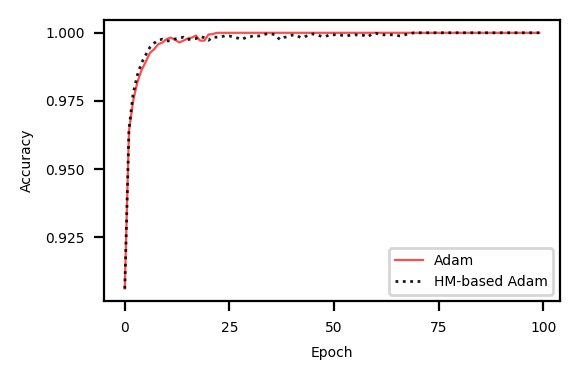

In [174]:
x1 = range(0, df1.shape[0])
x2 = range(0, df2.shape[0])
y1 = df1['accuracy'] 
y2 = df2['accuracy']  
plt.figure(figsize = (3,2), dpi = 200)
plt.plot(x1, y1, "r-", label = opti_name, linewidth = 0.8, alpha = 0.7)
plt.plot(x2, y2, "k:", label = 'HM-based ' + opti_name, linewidth = 1, alpha = 0.9) 
plt.ylabel('Accuracy' , fontdict = {'fontsize':5})
plt.xlabel('Epoch', fontdict = {'fontsize':5}) 
#plt.title("Loss", fontdict = {'fontname':'Times New Roman', 'fontsize':8})
plt.xticks(fontsize = 5)
plt.yticks(fontsize = 5)
plt.tight_layout()
plt.legend(prop={'size': 5})
#plt.savefig("graph.png",bbox_inches='tight',dpi=(300)) 
plt.show() 

Loss

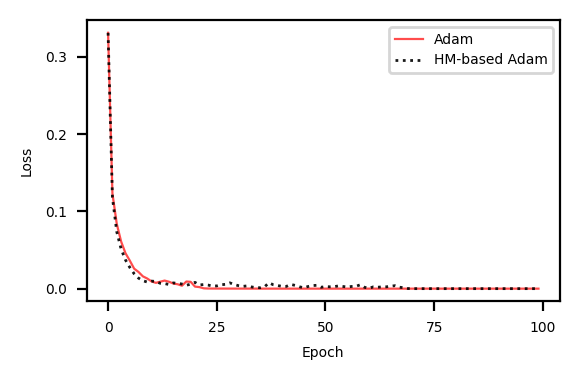

In [175]:
x1 = range(0, df1.shape[0])
x2 = range(0, df2.shape[0])
y1 = df1['loss'] 
y2 = df2['loss']   
plt.figure(figsize = (3,2), dpi = 200)
plt.plot(x1, y1, "r-", label = opti_name, linewidth = 0.8, alpha = 0.7)
plt.plot(x2, y2, "k:", label = 'HM-based ' + opti_name, linewidth = 1, alpha = 0.9) 
plt.ylabel('Loss' , fontdict = {'fontsize':5})
plt.xlabel('Epoch', fontdict = {'fontsize':5}) 
#plt.title("Loss", fontdict = {'fontname':'Times New Roman', 'fontsize':8})
plt.xticks(fontsize = 5)
plt.yticks(fontsize = 5)
plt.tight_layout()
plt.legend(prop={'size': 5})
#plt.savefig("graph.png",bbox_inches='tight',dpi=(300)) 
plt.show()  

###### Testing the model

Generic opimizer model

In [176]:
generic_testing = model_wihtout_hm.evaluate(X_test_normalized, y_test)
generic_testing  

313/313 [==============================] - 1s 2ms/step - loss: 0.1528 - accuracy: 0.9832


[0.15284374356269836, 0.9832000136375427]

HM based optimizer model

In [177]:
hm_testing = model_hm.evaluate(X_test_normalized, y_test)
hm_testing

313/313 [==============================] - 1s 2ms/step - loss: 0.1484 - accuracy: 0.9832


[0.14838193356990814, 0.9832000136375427]

#### Release the GPU memory